# Easiest way to work on a model

This example will guide you on how to create/modify a model (loss, architecture, hyperparameters)

First import some basics

In [1]:
import context # local npy file that add mlnowcasting directory to the path so we can import the mlnowcasting modules
import numpy as np # numpy is for general matrix operations
import torch # torch is the pytorch package with all the neccesary to run neural networks
import torch.nn as nn 
import matplotlib.pyplot as plt # to create all the plots

/s/chopin/d/proj/jcuomo/699/repository


Now, we import the mlnowcasting modules that we need.  

*Torch_Trainer* is the most important as it has the training loop, and you might need to play with it if you need to change how the data is fed to the model during the training, how the checkpoints are saved or loaded to resume training.  

*events_metrics* is just a function to show how good are the predictions, you can pick a different fx from the metric module if for example you want the metric plots

In [2]:
from mlnowcasting.utils.torch_trainer import Torch_Trainer
from mlnowcasting.utils.metrics import events_metrics

Set the paths of the training a validation dataset

In [3]:
dataset = '../data/datasets/example_dataset.npy'
val_dataset = '../data/datasets/example_dataset.npy'

Set the hyperparameters (affects only the training stage) and parameters (part of model definition).

In [4]:
params = {# training params
          'weight_decay'   : 0, 
          'eps'            : 1e-08, 
          'beta1'          : 0.9, 
          'beta2'          : 0.999, 
          'lr'             : 0.0001, 
          'lr_steps'       : 3, 
          'max_epochs'     : 20, 
          'batch'          : 4,
          'log_interval'   : 10, 
          'th'             : 20,
          'show'           : True,
          'fix'            : True,
          'save_filename'  : 'convGRU_16_16_logcosh.pth', 
          # model params
          'mode'           : 'absolute', 
          'in_frames'      : 16,
          'out_frames'     : 16, 
          'dropout'        : 0.0,  
          'n_filter'       : 32
           }         

Define the loss function: use torch functions and not numpy

In [5]:
def LogCosh(output, target):
    return torch.mean(torch.log(torch.cosh(output-target))) 

def get_lossF():
    return LogCosh

Define the model

In [6]:
def downsampling(in_channels, out_channels, typ='all'):
    if typ == 'res':
        k=(3,4,4)
        s=(1,2,2)
    elif typ == 'seq':
        k=(4,3,3)
        s=(2,1,1)
    else:
        k=(4,4,4)
        s=(2,2,2)
        
    return nn.Sequential(
        nn.Conv3d(in_channels,  out_channels, kernel_size=k, stride=s, padding=1),
        nn.ReLU(),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    ) 
 
def upsampling(in_channels, out_channels, typ='all'):
    if typ == 'res':
        k=(3,4,4)
        s=(1,2,2)
    elif typ == 'seq':
        k=(4,3,3)
        s=(2,1,1)
    else:
        k=(4,4,4)
        s=(2,2,2)
        
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels,  out_channels, kernel_size=k, stride=s, padding=1),
        nn.ReLU(),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    ) 
def upsamplingLast(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels,  out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.ConvTranspose3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    ) 

class Nowcasting(nn.Module):
    def __init__(self, n_filter):
        
        super(Nowcasting, self).__init__()
        dtype = torch.cuda.FloatTensor

        self.e_conv0 = downsampling(in_channels=1,          out_channels=n_filter)
        self.e_conv1 = downsampling(in_channels=n_filter,   out_channels=n_filter*2)
        self.e_conv2 = downsampling(in_channels=n_filter*2, out_channels=n_filter*3)
        self.e_conv3 = downsampling(in_channels=n_filter*3, out_channels=n_filter*4)
        
        self.d_conv3 = upsampling(in_channels=n_filter*4, out_channels=n_filter*3)
        self.d_conv2 = upsampling(in_channels=n_filter*3, out_channels=n_filter*2)
        self.d_conv1 = upsampling(in_channels=n_filter*2, out_channels=n_filter)
        self.d_conv0 = upsamplingLast(in_channels=n_filter,   out_channels=1)
        
        
    def forward(self, x):
        debug = False
        
        if debug: print(x.shape)
        e1 = self.e_conv0(x)
        if debug: print(e1.shape)
        e2 = self.e_conv1(e1)
        if debug: print(e2.shape)
        e3 = self.e_conv2(e2)
        if debug: print(e3.shape)
        e4 = self.e_conv3(e3)
        if debug: print(e4.shape)
        
        d3 = self.d_conv3(e4)
        if debug: print(d3.shape)
        d2 = self.d_conv2(d3+e3)
        if debug: print(d2.shape)
        d1 = self.d_conv1(d2+e2)
        if debug: print(d1.shape)
        y = self.d_conv0(d1+e1)
        if debug: print(y.shape)
        if debug: print('----------------')
                
        return y

    
def get_model(n_filters, dropout):
     return Nowcasting(n_filters)

Train the model. If there is already a checkpoint it will loaded and resume training up the the number of epochs indicated in the params.

Train Epoch: 10 Loss: 0.106579 Val_Loss: 0.106551


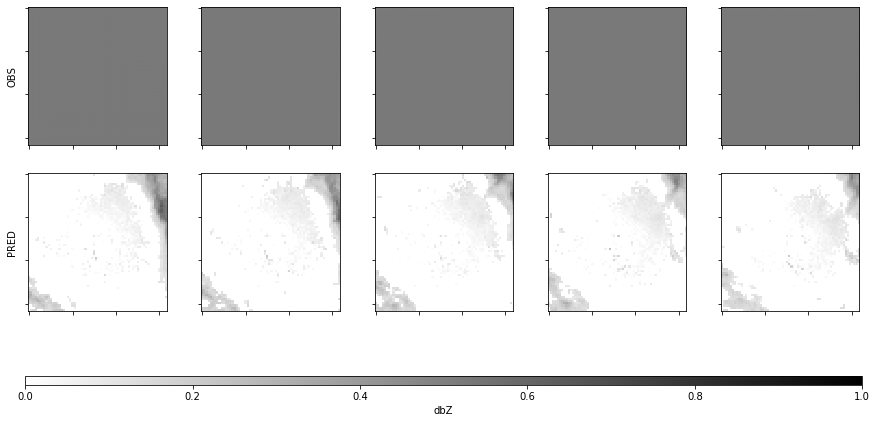

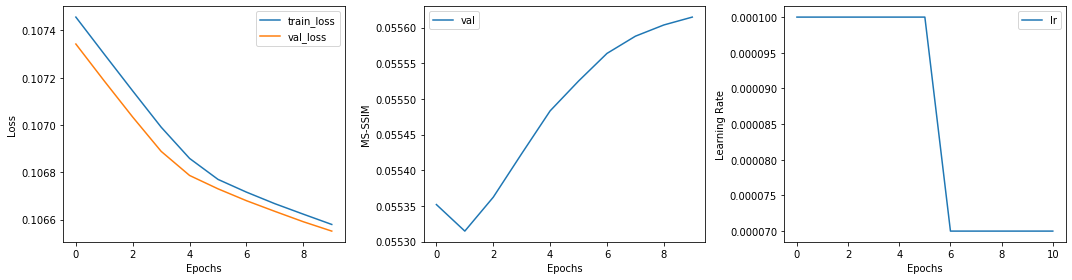

In [7]:
T = Torch_Trainer(dataset, val_dataset, get_model, get_lossF)
T.train(params)
T.save_checkpoint('./')

Evaluate the predictions

Original


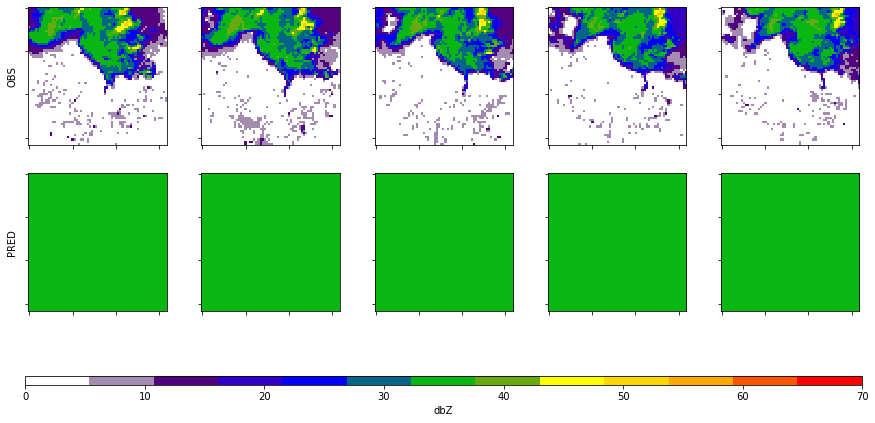

Converted to binary


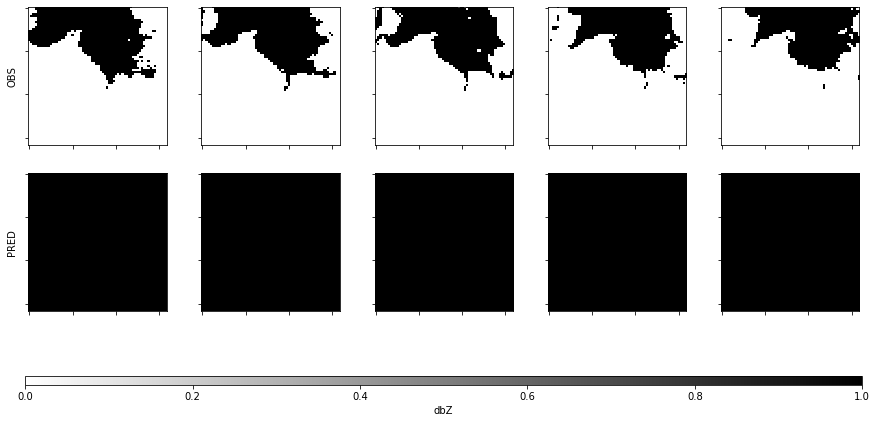

Mean across batches => columns are frames


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
MSE,993.078711,996.284271,990.153058,988.487988,988.346863,988.946436,990.281763,990.670007,991.788281,995.666785,996.551691,996.744342,997.907141,999.817755,987.902094,1010.728540
CSI (th=20 dBZ),0.133081,0.131665,0.129785,0.129248,0.129785,0.129492,0.129541,0.128857,0.127856,0.126440,0.125269,0.123364,0.123169,0.121753,0.120459,0.119873
FAR (th=20 dBZ),0.866919,0.868335,0.870215,0.870752,0.870215,0.870508,0.870459,0.871143,0.872144,0.873560,0.874731,0.876636,0.876831,0.878247,0.879541,0.880127
POD (th=20 dBZ),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ETS (th=20 dBZ),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ACC (th=20 dBZ),0.133081,0.131665,0.129785,0.129248,0.129785,0.129492,0.129541,0.128857,0.127856,0.126440,0.125269,0.123364,0.123169,0.121753,0.120459,0.119873
MAE,29.934248,29.999967,29.917621,29.897979,29.899400,29.913738,29.949743,29.975947,30.007849,30.096214,30.124153,30.140284,30.159978,30.198608,30.021183,30.389259
SSIM,-0.000036,-0.000135,0.000065,0.000053,0.000038,0.000046,0.000057,0.000062,0.000060,0.000072,0.000053,0.000050,0.000060,0.000047,0.000269,-0.000177





Mean across frames => columns are bacthes


,0,1,2,3,4,5,6,7,8,9
MSE,987.073006,865.463135,904.887314,1058.549110,1170.610138,899.199440,990.679916,1.074295e+03,1118.883759,869.957001
CSI (th=20 dBZ),0.181656,0.216675,0.194290,0.132904,0.080612,0.076614,0.048019,1.362610e-02,0.058578,0.265549
FAR (th=20 dBZ),0.818344,0.783325,0.805710,0.867096,0.919388,0.923386,0.951981,9.863739e-01,0.941422,0.734451
POD (th=20 dBZ),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000
ETS (th=20 dBZ),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
ACC (th=20 dBZ),0.181656,0.216675,0.194290,0.132904,0.080612,0.076614,0.048019,1.362610e-02,0.058578,0.265549
MAE,29.463865,27.210823,28.098396,31.094299,33.128479,29.090264,30.867683,3.237834e+01,32.658249,26.400956
SSIM,-0.000035,0.000034,0.000088,-0.000047,0.000034,0.000174,0.000044,-5.020600e-07,0.000070,0.000004





Mean across frames and batches


,1
MSE,993.959733
CSI (th=20 dBZ),0.126852
FAR (th=20 dBZ),0.873148
POD (th=20 dBZ),1.000000
ETS (th=20 dBZ),0.000000
ACC (th=20 dBZ),0.126852
MAE,30.039136
SSIM,0.000037


In [12]:
device = torch.device("cuda:0")
validation = np.load(val_dataset)[:] # limit the samples loaded if the dataset it's too large for GPU mem
fi = params['in_frames']
fo = params['out_frames']
# get context and target from dataset in the right dimensions
context = np.expand_dims(validation[:,:fi],1)/255
target  = np.expand_dims(validation[:,fi:fi+fo],1)/255
# make the prediction
prediction = T.model(torch.tensor(context).to(device).float())
# run the metrics
table = events_metrics(target, prediction, th_dbz=20, plot=True, printT=True, N=0)